# Problem Description
Tackle the Titanic dataset. A great place to start is on Kaggle.

### Notes on what I've done.
I went to kaggle and signed up for the competition! Sounds like a good way to make the assignment a little more fun. Also, that gives me convenient access to their dataset and a set of rules to work from. So I downloaded the dataset and here we go!

In [2]:
import pandas

raw_training = pandas.read_csv("titanic/train.csv")
raw_test = pandas.read_csv("titanic/test.csv")
example_output = pandas.read_csv("titanic/gender_submission.csv")

raw_training.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
raw_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
example_output.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [5]:
raw_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


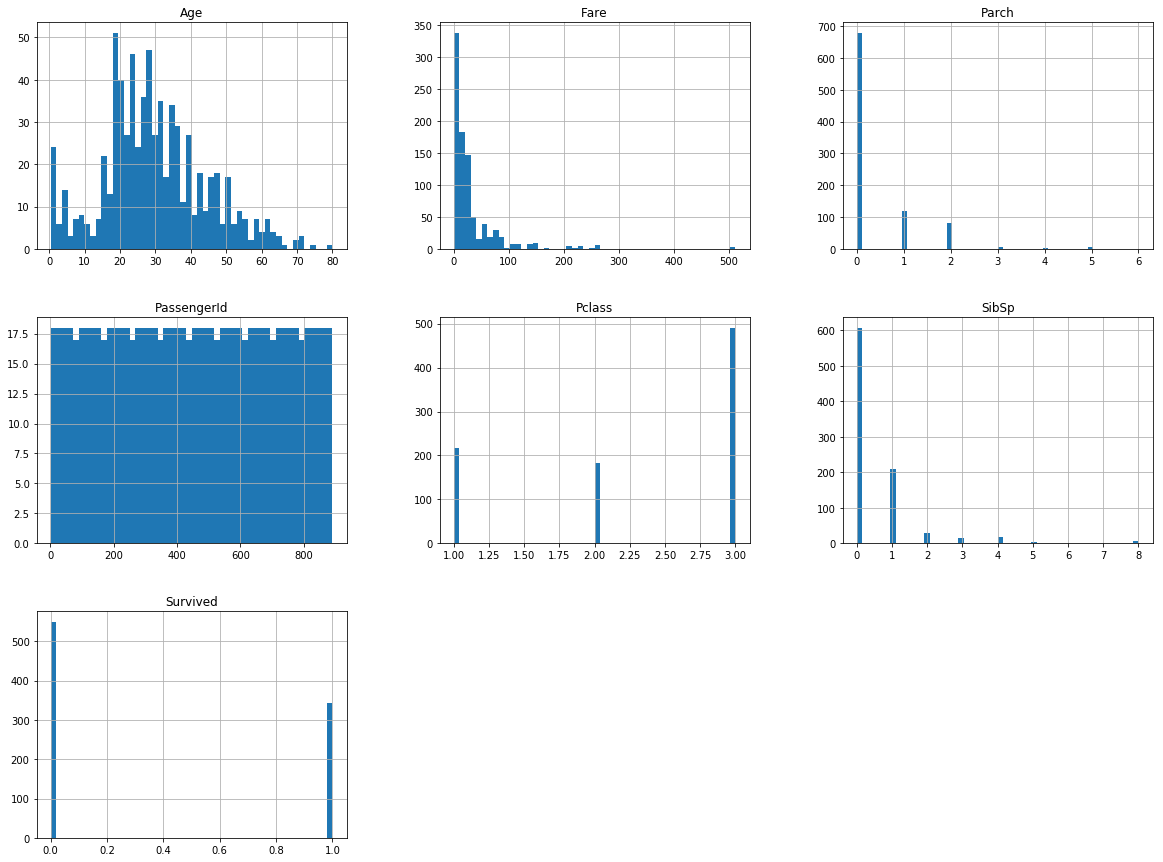

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

raw_training.hist(bins=50, figsize=(20,15))
plt.show()

A few observations:
 * I notice that the test set doesn't contain the survived column, which is fine because that's how the competition works, but I should pull that column out into its own array.
 * The PassengerID column will be needed to produce the final output, but will be worthless for the actual training, so it should be also be pulled into a separate array.
 * The Cabin column has lots of blanks in it. I'm not sure that I'll be able to suitably fill in the blanks, so I may have to drop that column entirely
 * The name column is going to be tricky to use. The only way I can think of currently that this info will be useful is if I can use it to group people into families. There may be a correlation between families and survival. That will take some data scrubbing though. I will need to separate the first and last name into their own columns, as well as first and last maiden name.
 * Age is definitely pertinent, but it has some null values that I will need to fill in
 * I will need to create mappings for a few names to convert them into usable numerical values: sex, embarked, and name
 * It looks like the 'fare' column might have some invalid 0s or something, it will need a closer look

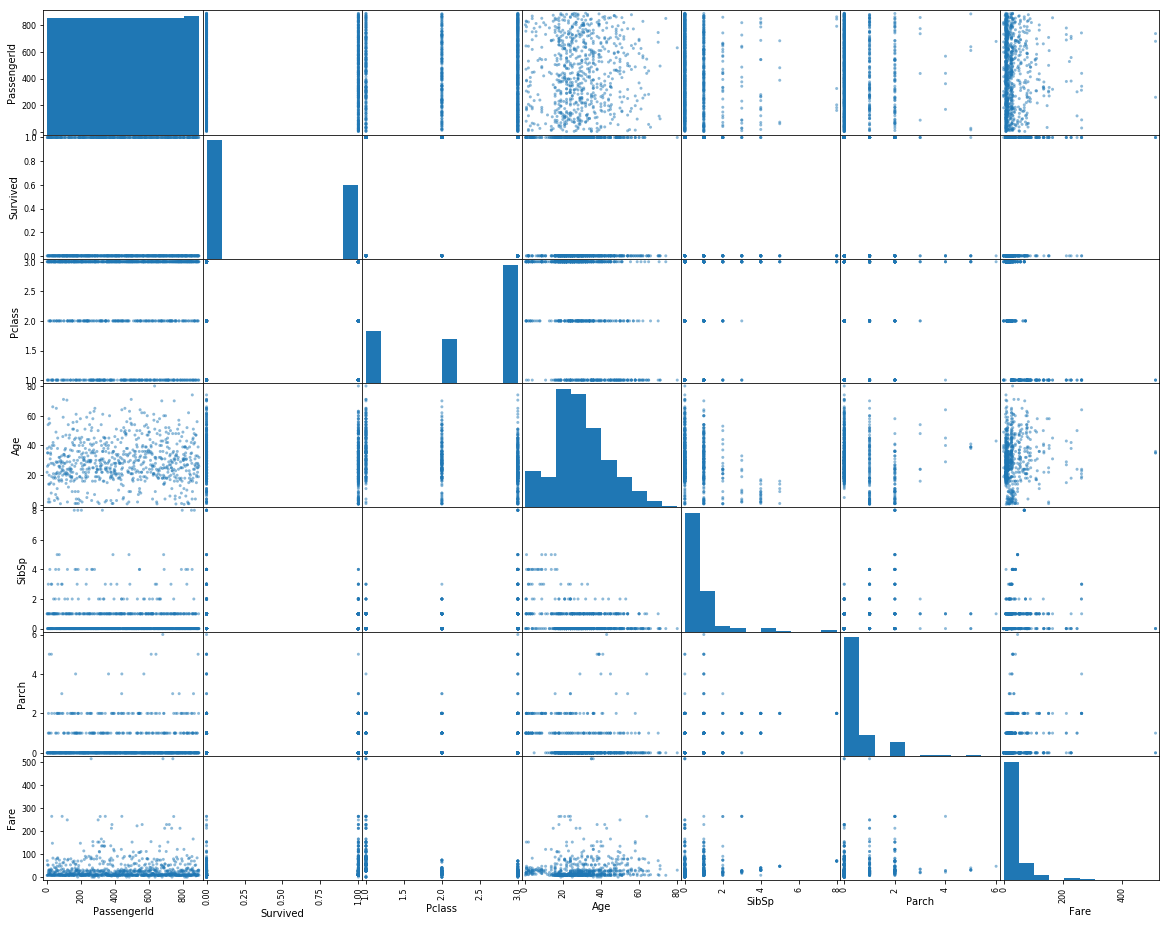

In [7]:
#Ok, time to look for correlations
from pandas.plotting import scatter_matrix

vals = scatter_matrix(raw_training, figsize=(20,16))


Well, I actually didn't get much of anything from that. Too many of the values are distinct. Lets clean things up a little and then try again. (Kaggle already split off a test set, so I don't need to worry about that)

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())
])

column_transform = ColumnTransformer(transformers=[
    ('numerical', numeric_pipeline, ["Age", "Fare"]),
    ('categorical', categorical_pipeline, ["Sex", "Embarked", "Pclass"]),
    ('passthrough', "passthrough", ["SibSp", "Parch"])
])

labels = raw_training["Survived"].copy()
training = raw_training.drop("Survived", axis=1)
training = column_transform.fit_transform(training, labels)

Names = ["Age", "Fare" ]
name, pipeline, columns = column_transform.transformers_[1]
name, transform = pipeline.steps[-1]
i = 0
for cat_cols in transform.categories_:
    curColName = columns[i]
    i += 1
    for cat in cat_cols:
        Names.append(curColName + "_" + str(cat))
Names.append("SibSp")
Names.append("Parch")

training = pandas.DataFrame(training, columns=Names)

#print(column_transform.get_feature_names())
print(labels.head())
print(training.head())

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64
        Age      Fare  Sex_female  Sex_male  Embarked_C  Embarked_Q  \
0 -0.592481 -0.502445         0.0       1.0         0.0         0.0   
1  0.638789  0.786845         1.0       0.0         1.0         0.0   
2 -0.284663 -0.488854         1.0       0.0         0.0         0.0   
3  0.407926  0.420730         1.0       0.0         0.0         0.0   
4  0.407926 -0.486337         0.0       1.0         0.0         0.0   

   Embarked_S  Pclass_1  Pclass_2  Pclass_3  SibSp  Parch  
0         1.0       0.0       0.0       1.0    1.0    0.0  
1         0.0       1.0       0.0       0.0    1.0    0.0  
2         1.0       0.0       0.0       1.0    0.0    0.0  
3         1.0       1.0       0.0       0.0    1.0    0.0  
4         1.0       0.0       0.0       1.0    0.0    0.0  


Some potential algorithms to try:
 * naieve bays
 * Decision Trees
 * Random Forests
 * AdaBoost

LogisticRegression: 0.799210(0.027443)
GaussianNB: 0.785801(0.029810)
DecisionTreeClassifier: 0.784552(0.036934)
RandomForestClassifier: 0.807100(0.046719)
AdaBoostClassifier: 0.812705(0.030004)
KNeighborsClassifier: 0.808123(0.034668)
SVC: 0.828336(0.034192)


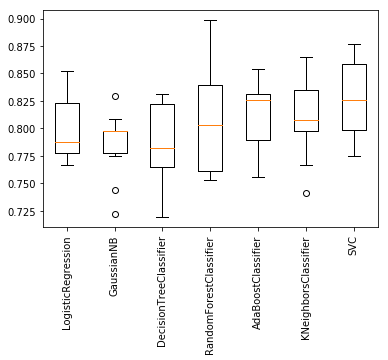

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

models = [
    LogisticRegression(solver="lbfgs"),
    GaussianNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100),
    AdaBoostClassifier(),
    KNeighborsClassifier(),
    SVC(gamma='scale'),
]

names=[]
scores = []
for model in models:
    score = cross_val_score(model, training, labels, cv=10, scoring='accuracy', n_jobs=-1)
    scores.append(score)
    names.append(type(model).__name__)
    print("%s: %f(%f)" % (type(model).__name__, score.mean(), score.std()))
    
plt.boxplot(scores)
plt.xticks(np.arange(len(names))+1,names,rotation=90)
plt.show()

Interesting results. To me the RandomForests, AdaBoost, and SVC look the most promising. Of those RandomForests looks the weekest, so I'll tune it last and only if I have enough time.

I'll start with SVC

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

def tune_SVC(data, labels):
    param_grid = { 
        "C": [0.5, 1.0, 1.5, 3.0],
        "gamma": ["auto", "scale"],
        "degree": [1,3,6],
        "coef0": [0,0.3,0.6,0.9],
        "shrinking": [False,True],
        "tol": [1e-2, 1e-3, 1e-5],
        "random_state":[42]
    }

    search = GridSearchCV(LinearSVC(), param_grid, n_jobs=-1, cv=5)
    search.fit(data, labels)
    print("Best Params: ", search.best_params_)
    print("Best Score: ", search.best_score_)
    print("Refit Time: ", search.refit_time_)

tune_SVC(training, labels)

Best Params:  {'C': 1.5, 'coef0': 0, 'degree': 1, 'gamma': 'auto', 'kernel': 'rbf', 'random_state': 42, 'shrinking': False, 'tol': 0.01}
Best Score:  0.8305274971941639
Refit Time:  0.016153812408447266


Well, that was a little underwhelming. Lets try adaboost.

In [12]:
def tune_AdaBoost(data, labels):
    param_grid = { 
        "n_estimators": [10,50,100,500,1000,5000],
        "learning_rate": [0.1,0.4,0.9,1.0,1.5,3,5],
        "random_state":[42]
    }

    search = GridSearchCV(AdaBoostClassifier(), param_grid, n_jobs=-1, cv=5, iid=False)
    search.fit(data, labels)
    print("Best Params: ", search.best_params_)
    print("Best Score: ", search.best_score_)
    print("Refit Time: ", search.refit_time_)

tune_AdaBoost(training, labels)

Best Params:  {'learning_rate': 1.5, 'n_estimators': 100, 'random_state': 42}
Best Score:  0.8137509322512658
Refit Time:  0.08994722366333008


Well, that wasn't very good either, time to reexamine my data. One of those really ought to have gotten a better score than that. Lets start by getting a little fancier with the confusion matrix

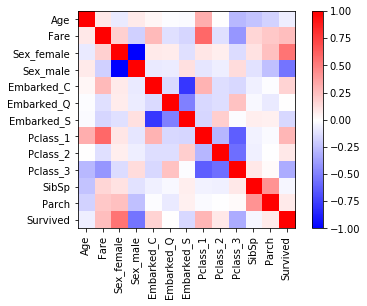

In [13]:
def show_correlation(data, labels):
    correlations = data.join(labels).corr()
    plt.imshow(correlations, cmap='bwr', interpolation='Nearest', vmin=-1.0, vmax=1.0)
    tmp = plt.xticks(np.arange(len(list(correlations))),list(correlations),rotation=90)
    tmp = plt.yticks(np.arange(len(list(correlations))),list(correlations))
    plt.colorbar()
    plt.show()

show_correlation(training, labels)

Ok, having failed to visualize my improved data (I went back and reworked things to add the new column names back into the dataframe to make this easier), I failed to notice that Sex_female and Sex_male are very highly related. lol. So I'll drop one of them. 

Likewise, it seems that Age has almost nothing to do with survival and is related to several other items. I'll drop it too.

SibSp and Parch are relatively closely related, so I'll drop SibSp. It's even less related to survival than Parch.

Looking closer, it seems that I might ought to have left passenger class as a single numeric column. The three columns it turned into are all highly related to each other and all have a moderate tie to survival as well.

In [116]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

numeric_pipeline2 = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

categorical_pipeline2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())
])

ordinal_pipeline2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])

column_transform2 = ColumnTransformer(transformers=[
    ('numerical', numeric_pipeline2, ["Fare"]),
    ('ordinal', ordinal_pipeline2, ["Sex"]),
    ('categorical', categorical_pipeline2, ["Embarked", "Pclass"]),
    ('passthrough', "passthrough", ["Parch", "SibSp"])
])

labels = raw_training["Survived"].copy()
training2 = raw_training.drop("Survived", axis=1)
training2 = column_transform2.fit_transform(training2, labels)

def getOneHotEncoderColumns(encoder, colNames):
    names = []
    i = 0
    for cat_cols in encoder.categories_:
        curColName = colNames[i]
        i += 1
        for cat in cat_cols:
            names.append(curColName + "_" + str(cat))
    return names

Names2 = ["Fare", "Sex"]
name, pipeline, columns = column_transform2.transformers_[2]
name, transform = pipeline.steps[-1]
for name in getOneHotEncoderColumns(transform, columns):
    Names2.append(name)
Names2.append("Parch")
Names2.append("SibSp")

training2 = pandas.DataFrame(training2, columns=Names2)
print(training2.head())

       Fare  Sex  Embarked_C  Embarked_Q  Embarked_S  Pclass_1  Pclass_2  \
0 -0.502445  1.0         0.0         0.0         1.0       0.0       0.0   
1  0.786845  0.0         1.0         0.0         0.0       1.0       0.0   
2 -0.488854  0.0         0.0         0.0         1.0       0.0       0.0   
3  0.420730  0.0         0.0         0.0         1.0       1.0       0.0   
4 -0.486337  1.0         0.0         0.0         1.0       0.0       0.0   

   Pclass_3  Parch  SibSp  
0       1.0    0.0    1.0  
1       0.0    0.0    1.0  
2       1.0    0.0    0.0  
3       0.0    0.0    1.0  
4       1.0    0.0    0.0  


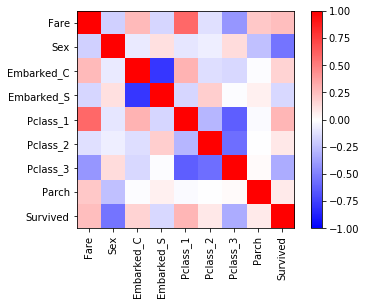

In [23]:
training3 = training2.drop(["SibSp", "Embarked_Q"], axis=1)
show_correlation(training3, labels)

In [24]:
tune_AdaBoost(training3, labels)

Best Params:  {'learning_rate': 1.0, 'n_estimators': 1000, 'random_state': 42}
Best Score:  0.8025587039021034
Refit Time:  0.7773218154907227


In [ ]:
#tune_SVC(training3, labels)

Well, that was taking a very long time to compute, despite the small size of the dataset, so I'm going to leave it alone and pick up the random forests instead

In [164]:
from sklearn.model_selection import RandomizedSearchCV

def tune_randForest(data, labels):
    param_grid = { 
        "n_estimators": [10,50,100,500,1000,5000],
        "max_depth": [5, 10, 50, 100, None],
        "min_samples_split": [2, 4, 8, 12],
        "min_samples_leaf": [1, 2, 4, 8],
        "min_weight_fraction_leaf": [0, 0.1, 0.4],
        "max_features": ["auto", "log2"],
        "max_leaf_nodes": [None, 500, 300, 100],
        "min_impurity_decrease": [0, 0.1, 0.3],
        "random_state":[42]
    }

    search = RandomizedSearchCV(RandomForestClassifier(), param_grid, n_iter=10000, n_jobs=-1, cv=5, iid=False)
    search.fit(data, labels)
    print("Best Params: ", search.best_params_)
    print("Best Score: ", search.best_score_)
    print("Refit Time: ", search.refit_time_)

tune_randForest(training3, labels)

Best Params:  {'random_state': 42, 'n_estimators': 100, 'min_weight_fraction_leaf': 0, 'min_samples_split': 2, 'min_samples_leaf': 2, 'min_impurity_decrease': 0, 'max_leaf_nodes': 300, 'max_features': 'log2', 'max_depth': 5}
Best Score:  0.8171027457038422
Refit Time:  0.07300758361816406


Well, still not very good. Lets go back to some more feature engineering. 

There's one feature that I haven't used at all that has some potential. The historical record seems to indicate that families ties had a big impact on survival. So maybe if I extract last names and then one-hot encode them I'll be able to get some more improvement.

In [142]:
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import re

regex = re.compile("(.*?),")
groupNum = 1
def applyRegex(val):
    match = regex.search(val)
    newVal = ""
    if (match):
        newVal = match.group(groupNum)
    if (newVal is None):
        newVal = ""
    return newVal

class RegexTransform(BaseEstimator, TransformerMixin):
    def __init__(self, regex=".*", groupNum=0):
        self.regex = re.compile(regex)
        self.groupNum = groupNum
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.applymap(applyRegex)

name_col = raw_training["Name"].copy()
namesPipeline = Pipeline(steps=[
    ('lastName', RegexTransform()),
    ('oneHot', OneHotEncoder(sparse=False))
])
colTransform2 = ColumnTransformer(transformers=[
    ('names', namesPipeline, ["Name"]),
])
encoded = colTransform2.fit_transform(raw_training.drop("Survived", axis=1))


name, pipeline, columns = colTransform2.transformers_[0] 
name, transform = pipeline.steps[-1]
lastNameCols = getOneHotEncoderColumns(transform, ["LastName"])
encoded_df = pandas.DataFrame(encoded, columns=lastNameCols)

trainingWithNames = training.join(encoded_df)

print(trainingWithNames.head())



        Age      Fare  Sex_female  Sex_male  Embarked_C  Embarked_Q  \
0 -0.592481 -0.502445         0.0       1.0         0.0         0.0   
1  0.638789  0.786845         1.0       0.0         1.0         0.0   
2 -0.284663 -0.488854         1.0       0.0         0.0         0.0   
3  0.407926  0.420730         1.0       0.0         0.0         0.0   
4  0.407926 -0.486337         0.0       1.0         0.0         0.0   

   Embarked_S  Pclass_1  Pclass_2  Pclass_3  ...  LastName_Yousseff  \
0         1.0       0.0       0.0       1.0  ...                0.0   
1         0.0       1.0       0.0       0.0  ...                0.0   
2         1.0       0.0       0.0       1.0  ...                0.0   
3         1.0       1.0       0.0       0.0  ...                0.0   
4         1.0       0.0       0.0       1.0  ...                0.0   

   LastName_Yrois  LastName_Zabour  LastName_Zimmerman  \
0             0.0              0.0                 0.0   
1             0.0             

In [155]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest

kbest = SelectKBest(mutual_info_classif, k=30)
trainingWithNames_reduced = kbest.fit_transform(trainingWithNames, labels)

In [156]:
tune_AdaBoost(trainingWithNames_reduced, labels)

Best Params:  {'learning_rate': 1.5, 'n_estimators': 1000, 'random_state': 42}
Best Score:  0.7958171308683955
Refit Time:  0.8377938270568848


In [ ]:
tune_randForest(trainingWithNames_reduced, labels)

Well, that reduced number of names didn't go as well as I had hoped, so I'll just try using all of them and see how it goes.

In [162]:
tune_randForest(trainingWithNames, labels)

Best Params:  {'random_state': 42, 'n_estimators': 5000, 'min_weight_fraction_leaf': 0, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 0, 'max_leaf_nodes': None, 'max_features': 'log2', 'max_depth': 50}
Best Score:  0.8395563210980119
Refit Time:  6.823760747909546


So training a random forest with all 600+ columns (mostly generated by one-hot encoding each passenger's last name) seems to have gotten me another percent and a half of accuracy, but it took around 6 hours to train. In a real world scenarion I would probably just stick with the reduced set of columns

I'm curious about how untuned accuracy changes with the expanded dataset.

LogisticRegression: 0.806972(0.021103)
GaussianNB: 0.475845(0.014285)
DecisionTreeClassifier: 0.831697(0.022385)
RandomForestClassifier: 0.827222(0.018667)
AdaBoostClassifier: 0.795824(0.045260)
KNeighborsClassifier: 0.801416(0.025140)
SVC: 0.792346(0.018673)


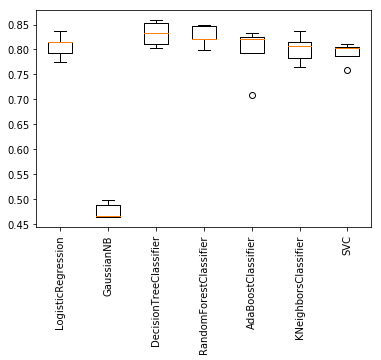

In [170]:
models = [
    LogisticRegression(solver="lbfgs"),
    GaussianNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100),
    AdaBoostClassifier(),
    KNeighborsClassifier(),
    SVC(gamma='scale'),
]

names=[]
scores = []
for model in models:
    score = cross_val_score(model, trainingWithNames, labels, cv=5, scoring='accuracy', n_jobs=-1)
    scores.append(score)
    names.append(type(model).__name__)
    print("%s: %f(%f)" % (type(model).__name__, score.mean(), score.std()))
    
plt.boxplot(scores)
plt.xticks(np.arange(len(names))+1,names,rotation=90)
plt.show()

Wow, GaussianNB tanked right there. Lest take a closer look at the others

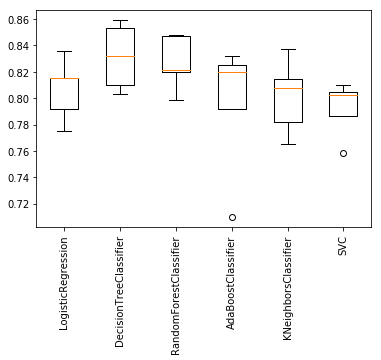

In [171]:
del(scores[1])
del(names[1])
plt.boxplot(scores)
plt.xticks(np.arange(len(names))+1,names,rotation=90)
plt.show()

Ok, the DecisionTreeClassifier looks a lot more interesting here. Lets see what happens if we tune it.

In [209]:
def tune_decisionTree(data, labels):
    param_grid = { 
        "splitter": ["best", "random"],
        "criterion": ["gini", "entropy"],
        "min_samples_split": [19, 20, 21],
        "min_samples_leaf": [1,3],
        "min_weight_fraction_leaf": [0],
        "max_leaf_nodes": [None],
        "min_impurity_decrease": [0, 0.2],
        "random_state":[42]
    }

    search = GridSearchCV(DecisionTreeClassifier(), param_grid, n_jobs=-1, cv=5, iid=False)
    search.fit(data, labels)
    print("Best Params: ", search.best_params_)
    print("Best Score: ", search.best_score_)
    print("Refit Time: ", search.refit_time_)
    return search.best_estimator_ 

best_dt = tune_decisionTree(trainingWithNames, labels)

Best Params:  {'criterion': 'entropy', 'max_leaf_nodes': None, 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0, 'random_state': 42, 'splitter': 'best'}
Best Score:  0.835061868148197
Refit Time:  0.0305173397064209


In [191]:
tune_decisionTree(trainingWithNames_reduced, labels)

Best Params:  {'criterion': 'entropy', 'max_leaf_nodes': None, 'min_impurity_decrease': 0, 'min_samples_leaf': 3, 'min_samples_split': 19, 'min_weight_fraction_leaf': 0, 'random_state': 42, 'splitter': 'best'}
Best Score:  0.8137381653295088
Refit Time:  0.0017464160919189453


In [193]:
tune_decisionTree(training, labels)

Best Params:  {'criterion': 'gini', 'max_leaf_nodes': None, 'min_impurity_decrease': 0, 'min_samples_leaf': 3, 'min_samples_split': 19, 'min_weight_fraction_leaf': 0, 'random_state': 42, 'splitter': 'best'}
Best Score:  0.8137823885279278
Refit Time:  0.001981973648071289


Lets look at what our best decision tree decided were the most significant features

In [211]:
importance = zip(best_dt.feature_importances_, trainingWithNames.columns.tolist())
mostImport = sorted(importance, reverse=True)
list(mostImport)

[(0.26224584077368274, 'Sex_male'),
 (0.13548546818600002, 'Fare'),
 (0.09273036965814722, 'Age'),
 (0.08632419561165247, 'Pclass_3'),
 (0.01550350532129759, 'LastName_Asplund'),
 (0.013304454223604026, 'SibSp'),
 (0.012902968940342173, 'Pclass_2'),
 (0.011912229481219984, 'LastName_Allison'),
 (0.010048949169836474, 'LastName_Turpin'),
 (0.009716697127559409, 'LastName_Beane'),
 (0.009700439837560828, 'LastName_Williams'),
 (0.009059187020395218, 'LastName_Barah'),
 (0.008974688592786263, 'LastName_Moubarek'),
 (0.008618288854542812, 'LastName_Henry'),
 (0.008571633934475497, 'LastName_Stranden'),
 (0.008190897471306248, 'LastName_Moran'),
 (0.008184177319090276, 'LastName_Persson'),
 (0.008033042943587776, 'LastName_Harris'),
 (0.0078628561708925, 'LastName_Jansson'),
 (0.007588536029505206, 'LastName_Cohen'),
 (0.007349354906214161, 'LastName_Padro y Manent'),
 (0.007137445465497173, 'LastName_Moss'),
 (0.006947319684701549, 'LastName_Lulic'),
 (0.006774996081242183, 'LastName_Sundm

Aha, lots of significant names, which explains why the decision with all the names performed better and the version trained with only 20 significant features did not perform so well. I should have picked a number more akin to 80 or 100.

-------------------------------------------

Anyhow, lets go ahead and use our best decision tree to make the predictions

In [213]:
raw_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Oops, I just realized that I didn't do a very good of setting up my pipeline and it won't be very easy to reuse for processing the test data for predictions. Lets clean that up a little.

In [260]:
labels = raw_training["Survived"].copy()
new_training = raw_training.drop("Survived", axis=1)

class TitanicDataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.numeric_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer()),
            ('scaler', StandardScaler())
        ])

        self.categorical_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(sparse=False, handle_unknown ='ignore'))
        ])

        self.namesPipeline = Pipeline(steps=[
            ('lastName', RegexTransform()),
            ('oneHot', OneHotEncoder(sparse=False, handle_unknown ='ignore'))
        ])

        self.column_transform = ColumnTransformer(sparse_threshold=0,transformers=[
            ('numerical', self.numeric_pipeline, ["Age", "Fare"]),
            ('categorical', self.categorical_pipeline, ["Sex", "Embarked", "Pclass"]),
            ('passthrough', "passthrough", ["SibSp", "Parch"]),
            ('names', self.namesPipeline, ["Name"])
        ])
    
    def fit(self, data, labels=None):
        self.column_transform.fit(data, labels)
        
        self.features = ["Age", "Fare" ]
        name, pipeline, columns = self.column_transform.transformers_[1]
        name, transform = pipeline.steps[-1]
        self.features += getOneHotEncoderColumns(transform, columns)
        self.features += ["SibSp", "Parch"]
        name, pipeline, columns = self.column_transform.transformers_[3] 
        name, transform = pipeline.steps[-1]
        self.features += getOneHotEncoderColumns(transform, columns)
        return self
    
    def transform(self, data):
        tmpData = self.column_transform.transform(data)

        newNames = ["Age", "Fare" ]
        name, pipeline, columns = self.column_transform.transformers_[1]
        name, transform = pipeline.steps[-1]
        newNames += getOneHotEncoderColumns(transform, columns)
        newNames += ["SibSp", "Parch"]
        name, pipeline, columns = self.column_transform.transformers_[3] 
        name, transform = pipeline.steps[-1]
        newNames += getOneHotEncoderColumns(transform, columns)
        
        df = pandas.DataFrame(tmpData, columns=newNames)
        #dummies = pandas.DataFrame(columns=self.features)
        #return pandas.concat((df, dummies)).fillna(0)
        return df

titanicTransformer = TitanicDataTransformer()
clean_training = titanicTransformer.fit_transform(new_training)

print(clean_training.head())
print(trainingWithNames.head())

        Age      Fare  Sex_female  Sex_male  Embarked_C  Embarked_Q  \
0 -0.592481 -0.502445         0.0       1.0         0.0         0.0   
1  0.638789  0.786845         1.0       0.0         1.0         0.0   
2 -0.284663 -0.488854         1.0       0.0         0.0         0.0   
3  0.407926  0.420730         1.0       0.0         0.0         0.0   
4  0.407926 -0.486337         0.0       1.0         0.0         0.0   

   Embarked_S  Pclass_1  Pclass_2  Pclass_3  ...  Name_Yousseff  Name_Yrois  \
0         1.0       0.0       0.0       1.0  ...            0.0         0.0   
1         0.0       1.0       0.0       0.0  ...            0.0         0.0   
2         1.0       0.0       0.0       1.0  ...            0.0         0.0   
3         1.0       1.0       0.0       0.0  ...            0.0         0.0   
4         1.0       0.0       0.0       1.0  ...            0.0         0.0   

   Name_Zabour  Name_Zimmerman  Name_de Messemaeker  Name_de Mulder  \
0          0.0             

Good looks like our new version and our old version match. Now lets spruce up that test data.

In [261]:
test = titanicTransformer.transform(raw_test)
test.head()

,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,...,Name_Yousseff,Name_Yrois,Name_Zabour,Name_Zimmerman,Name_de Messemaeker,Name_de Mulder,Name_de Pelsmaeker,Name_del Carlo,Name_van Billiard,Name_van Melkebeke
0,0.369449,-0.490783,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.331378,-0.507479,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.485693,-0.453367,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.207709,-0.474005,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.592481,-0.401017,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Excellent, now we are ready to actually make predictions!

In [266]:
predictions = best_dt.predict(test)
predictions = list(zip(raw_test["PassengerId"], predictions))
df = pandas.DataFrame(predictions, columns=["PassengerID", "Survived"])
df.to_csv('test_predictions.csv', index=False)

submitted to kaggle and got the final scoring on my test: 0.77511
Not too bad for a first try and my second ML algorithm. Still, plenty of room for improvement

### Time/Task Log   | Activity Type: Non-Direct

| Date                           | Duration in Minutes       | Specific Task/Activity        |
|--------------------------------|---------------------------|-------------------------------|
| 1/19/19                        | 180                       | Reading Textbook Chapters 1-3 |
| 1/26/19                        | 180                       | Working on Project 1          |
| 2/2/19                         | 420                       | Working on Project 1          |
| 2/4/19                         | 90                        | Working on Project 1          |
| 2/6/19                         | 60                        | Working on Project 1          |
| 2/9/19                         | 480                       | Working on Project 1          |
| 2/11/19                        | 480                       | Working on Project 1          |
|                                                                                            |
| Sum for current report         | 1,890                     |                               |
| Cumulative sum for this course | 1,890                     |                               |